# Dokumentation

In:

OSM .PBF Datei (es wird die lexikalisch kleinste .PBF-Datei im Verzeichnis gewählt)

Out (zum Import in SIR 3S):

SHP-Dateien

zugehörige SHP-Importdefinitionsdatei

In [1]:
# KOS auf welches bei der Verarbeitung transformiert wird
crs="EPSG:25832"

In [2]:
# Verschiebung RL
xoff=2.
yoff=0.
zoff=0.

In [3]:
try:
    import Rm
except:
    from PT3S import Rm

In [4]:
# Daten zur Hintergrundkarte
hKartenFormat=Rm.DINA4q # Grundformat
# Image entspricht dann in x dem vorgegebenen Grundformat
# das Image wird in y so angepasst, dass es in x/y dem Kartenausschnitt entspricht; andernfalls haette das Image weiße Ränder
hKartenAufloesung=2*Rm.dpiSize

In [5]:
import logging
import sys
import re
import os
import importlib
import warnings
import math

import pandas as pd
import geopandas
import folium

import pyrosm
from pyrosm.data import sources

from shapely import geometry, ops

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as font_manager

import contextily as cx

import numpy as np
import shapely
import osmnx as ox

import sys
import os
import glob
import re

from xml.etree.ElementTree import ElementTree
from xml.etree.ElementTree import Element
from xml.etree.ElementTree import SubElement
import xml.etree.ElementTree as ET

from PIL import Image

logFile='Planungsbeispiel.log' 

logging.basicConfig(filename=logFile
                   ,filemode='w'                 
                   ,level=logging.DEBUG
                   ,format="%(asctime)s ; %(name)-60s ; %(levelname)-7s ; %(message)s"                 
                   )    

logger = logging.getLogger()  

consoleHandler = logging.StreamHandler(sys.stdout)
consoleHandler.setFormatter(logging.Formatter("%(levelname)-7s ; %(message)s"))
consoleHandler.setLevel(logging.INFO)

logger.addHandler(consoleHandler)

# .PBF-Datei ermitteln

In [6]:
pbfDateien=glob.glob('*.PBF')
pbfDateien

['Planungsbeispiel.pbf']

In [7]:
if len(pbfDateien) == 0:
    logger.error('keine PBF-Datei im Verzeichnis')
    sys.exit(0)
else:
    pbfDatei=sorted(pbfDateien)[0]
    logger.info('PBF-Datei: {:s}'.format(pbfDatei))

INFO    ; PBF-Datei: Planungsbeispiel.pbf


In [8]:
pbfDateiHead,ext=os.path.splitext(pbfDatei)
pbfDateiHead,ext

('Planungsbeispiel', '.pbf')

# .PBF-Datei einlesen und sichten

In [9]:
osm = pyrosm.OSM(pbfDatei)

In [10]:
buildings = osm.get_buildings()

<Axes: >

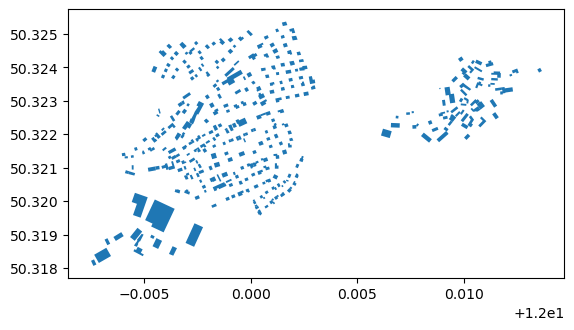

In [11]:
buildings.plot()

In [12]:
buildings.head()

,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,email,name,phone,url,website,building,amenity,id,timestamp,version,tags,osm_type,geometry
0,Gattendorf,DE,1,95185,Am Gewerbegebiet,None,None,None,None,None,industrial,None,119785055,0,-1,None,way,"POLYGON ((11.99518 50.32012, 11.99484 50.31951..."
1,Gattendorf,DE,5,95185,Am Gewerbegebiet,None,Max Pharma GmbH,None,None,None,industrial,None,119785060,0,-1,None,way,"POLYGON ((11.99737 50.31934, 11.99777 50.31922..."
2,Gattendorf,DE,3,95185,Am Gewerbegebiet,None,Arndt Fenstertechnik GmbH & Co. KG,None,None,None,industrial,None,119785063,0,-1,None,way,"POLYGON ((11.99551 50.32005, 11.99644 50.31977..."
3,None,None,None,None,None,None,None,None,None,None,industrial,None,119785064,0,-1,None,way,"POLYGON ((11.99252 50.31822, 11.99266 50.31826..."
4,None,None,None,None,None,None,None,None,None,None,industrial,None,119785067,0,-1,None,way,"POLYGON ((11.99346 50.31836, 11.99324 50.31861..."


<Axes: >

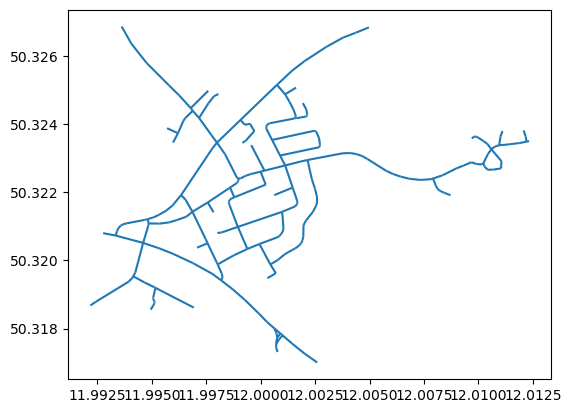

In [13]:
drive_net = osm.get_network(network_type="driving")
drive_net.plot()

In [14]:
drive_net.head(2)

,access,bicycle,foot,highway,lanes,maxspeed,motor_vehicle,name,oneway,ref,...,surface,tracktype,width,id,timestamp,version,tags,osm_type,geometry,length
0,None,None,None,residential,None,None,None,Am Sonnenbühl,None,None,...,None,None,None,24386111,0,-1,"{""traffic_sign"":""city_limit""}",way,"MULTILINESTRING ((12.00112 50.32279, 12.00089 ...",370.0
1,None,None,None,tertiary,None,None,None,Oelsnitzer Straße,None,HO 16,...,None,None,None,24633100,0,-1,None,way,"MULTILINESTRING ((11.99799 50.32346, 11.99907 ...",581.0


In [15]:
drive_net.columns

Index(['access', 'bicycle', 'foot', 'highway', 'lanes', 'maxspeed',
       'motor_vehicle', 'name', 'oneway', 'ref', 'service', 'surface',
       'tracktype', 'width', 'id', 'timestamp', 'version', 'tags', 'osm_type',
       'geometry', 'length'],
      dtype='object')

In [16]:
drive_net['id'].unique()

array([  24386111,   24633100,   24633101,   24633102,   24633104,
         27275245,   27275293,   28693697,   32598637,   38246569,
         38252021,   38252480,   39700311,   39785481,   39785483,
         39785484,   39785486,   39785488,   39785489,   39785491,
         39785492,   39785494,   39785495,   39785496,   39785498,
         39785499,   39785501,   39785520,  103882842,  103882853,
        166815824,  242013128,  295060742,  399954634,  408665320,
        408665322,  417777461,  417777463,  417777464,  529250452,
        529250453,  595926249,  595926250,  595926251,  595926850,
        744087055,  877460216,  901274325,  901730410,  901730411,
       1083020934, 1083853608], dtype=int64)

<Axes: >

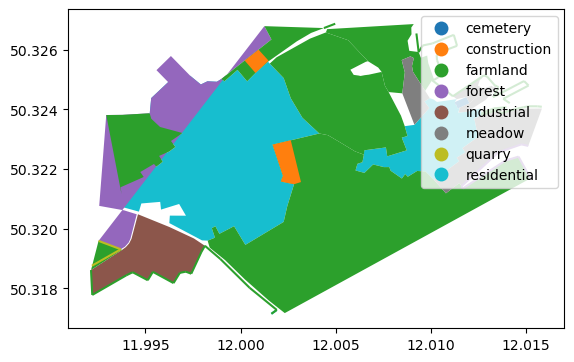

In [17]:
landuse = osm.get_landuse()
landuse.plot(column='landuse', legend=True) 

# Topologie ermitteln und sichten

In [18]:
nodes, edges = osm.get_network(nodes=True, network_type="driving")

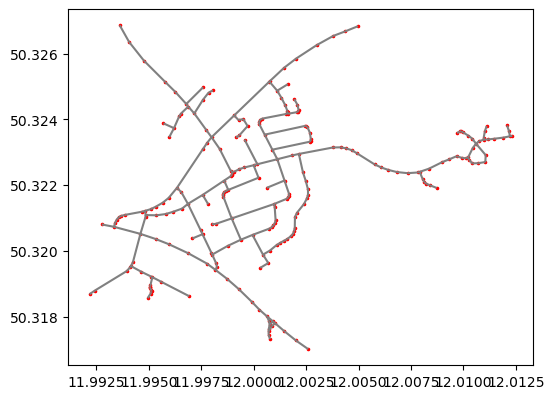

In [19]:
ax = edges.plot(figsize=(6,6), color="gray")
ax = nodes.plot(ax=ax, color="red", markersize=2.5)

In [20]:
nodes

,lon,lat,tags,timestamp,version,changeset,id,geometry
0,12.001123,50.322787,None,0,0,0,264607345,POINT (12.00112 50.32279)
1,12.000889,50.323078,None,0,0,0,476971289,POINT (12.00089 50.32308)
2,12.000521,50.323536,None,0,0,0,476971283,POINT (12.00052 50.32354)
3,12.000258,50.323863,None,0,0,0,264607348,POINT (12.00026 50.32386)
4,12.000255,50.323925,None,0,0,0,476971208,POINT (12.00026 50.32392)
...,...,...,...,...,...,...,...,...
243,12.008220,50.322047,None,0,0,0,9925370378,POINT (12.00822 50.32205)
244,12.008126,50.322099,None,0,0,0,9925370377,POINT (12.00813 50.32210)
245,12.008051,50.322186,None,0,0,0,9925370376,POINT (12.00805 50.32219)
246,12.012170,50.323639,None,0,0,0,9932392067,POINT (12.01217 50.32364)


In [21]:
type(nodes)

geopandas.geodataframe.GeoDataFrame

In [22]:
edges.columns

Index(['access', 'bicycle', 'foot', 'highway', 'lanes', 'maxspeed',
       'motor_vehicle', 'name', 'oneway', 'ref', 'service', 'surface',
       'tracktype', 'width', 'id', 'timestamp', 'version', 'tags', 'osm_type',
       'geometry', 'u', 'v', 'length'],
      dtype='object')

In [23]:
#edges['width'].unique()

In [24]:
type(edges)

geopandas.geodataframe.GeoDataFrame

In [25]:
#[id for id in edges['id'] if id not in drive_net['id']]

In [26]:
G = osm.to_graph(nodes, edges, graph_type="networkx")

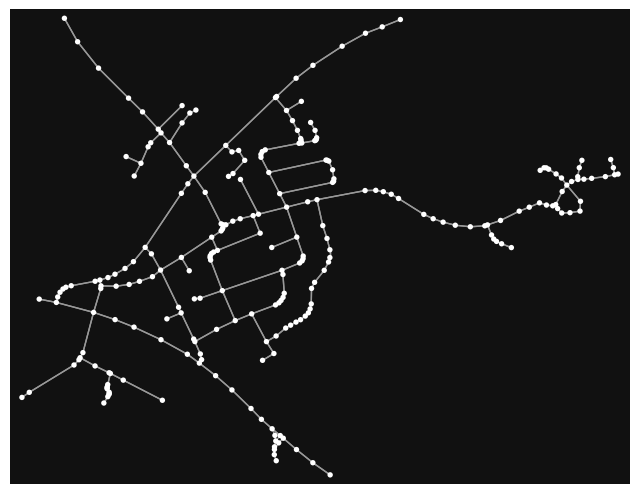

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [27]:
ox.plot_graph(G)

In [28]:
ox.folium.plot_graph_folium(G)

In [29]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

# Exports

## Allg

### CRS

In [30]:
nodes = nodes.to_crs(crs)
edges = edges.to_crs(crs)
buildings = buildings.to_crs(crs)

In [31]:
nodes.columns

Index(['lon', 'lat', 'tags', 'timestamp', 'version', 'changeset', 'id',
       'geometry'],
      dtype='object')

In [32]:
edges.columns

Index(['access', 'bicycle', 'foot', 'highway', 'lanes', 'maxspeed',
       'motor_vehicle', 'name', 'oneway', 'ref', 'service', 'surface',
       'tracktype', 'width', 'id', 'timestamp', 'version', 'tags', 'osm_type',
       'geometry', 'u', 'v', 'length'],
      dtype='object')

In [33]:
buildings.columns

Index(['addr:city', 'addr:country', 'addr:housenumber', 'addr:postcode',
       'addr:street', 'email', 'name', 'phone', 'url', 'website', 'building',
       'amenity', 'id', 'timestamp', 'version', 'tags', 'osm_type',
       'geometry'],
      dtype='object')

In [34]:
buildings.head()

,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,email,name,phone,url,website,building,amenity,id,timestamp,version,tags,osm_type,geometry
0,Gattendorf,DE,1,95185,Am Gewerbegebiet,None,None,None,None,None,industrial,None,119785055,0,-1,None,way,"POLYGON ((713208.903 5578514.427, 713187.856 5..."
1,Gattendorf,DE,5,95185,Am Gewerbegebiet,None,Max Pharma GmbH,None,None,None,industrial,None,119785060,0,-1,None,way,"POLYGON ((713368.411 5578434.250, 713397.408 5..."
2,Gattendorf,DE,3,95185,Am Gewerbegebiet,None,Arndt Fenstertechnik GmbH & Co. KG,None,None,None,industrial,None,119785063,0,-1,None,way,"POLYGON ((713232.928 5578508.013, 713300.375 5..."
3,None,None,None,None,None,None,None,None,None,None,industrial,None,119785064,0,-1,None,way,"POLYGON ((713028.410 5578295.611, 713038.293 5..."
4,None,None,None,None,None,None,None,None,None,None,industrial,None,119785067,0,-1,None,way,"POLYGON ((713094.455 5578314.157, 713077.601 5..."


### Spaltenberechnungen

In [35]:
nodes['NAME']=nodes['id'].astype('string')
nodes['X']=nodes.centroid.x # Excel-Import
nodes['Y']=nodes.centroid.y # Excel-Import
nodes['XKOR']=nodes['X']
nodes['YKOR']=nodes['Y']
nodes['ZKOR']=0.
nodes['BESCHREIBU']=''
nodes['IDREFERENZ']=nodes['id']

In [36]:
if not nodes[nodes.NAME.duplicated()].empty:
    logger.error('mehrfache Knotennamen!')

In [37]:
if max(nodes.NAME.str.len()) > 10:
    logger.error('Laenge von Roh-Knotennamen >10!')

In [38]:
edges['ID']=edges['id'] # Excel-Import
edges['BESCHREIBU']=edges.apply(lambda row: "OSM: Knoten {!s:s} -> Knoten {!s:s}; Länge: {:10.2f}".format(row['u'],row['v'],row['length']),axis=1)
edges['STRASSE']=edges.apply(lambda row: "{!s:s}".format(row['name']),axis=1)
edges['IDREFERENZ']=edges['id']
edges['SDO-Geometry']=edges.geometry # Excel-Import

In [39]:
#edges

In [40]:
buildings['IDREFERENZ']=buildings['id']
buildings['BESCHREIBU']=buildings.apply(lambda row: "{!s:s};{!s:s};{!s:s};{!s:s};{!s:s};{!s:s}".format( row['addr:city']
                                                                                                       ,row['addr:postcode']
                                                                                                       ,row['addr:street']
                                                                                                       ,row['addr:housenumber']
                                                                                                       ,row['name']
                                                                                                       ,row['building']),axis=1)

In [41]:
fwvb=buildings.copy(deep=True)

In [42]:
fwvb['W0']=fwvb.area

In [43]:
fwvb.set_geometry(fwvb.centroid,inplace=True)

## Excel

writer = pd.ExcelWriter('Planungsgebiet.xlsx')

crs="EPSG:25832"


#Knoten
#nodes = nodes.to_crs(crs)
nodes['NAME']=nodes['id'].astype('string')
nodes['KTYP']='QKON'
nodes['X']=nodes.centroid.x
nodes['Y']=nodes.centroid.y
nodes['ZKOR']=0.
nodes['QM_EIN']=0.
nodes['P']=1.
nodes['LFAKT']=1.
nodes['BESCHREIBUNG']=''
nodes['IDREFERENZ']=''
nodes['STATUS']=''
nodes.to_excel(writer,'KNOT',index=False,columns=['NAME','KTYP','X','Y','ZKOR','QM_EIN','P','LFAKT','BESCHREIBUNG','IDREFERENZ','STATUS'])

df=nodes[['NAME','KTYP','X','Y','ZKOR','QM_EIN','P','LFAKT','BESCHREIBUNG','IDREFERENZ','STATUS']]
for column in df:
    
    column_width = max(df[column].astype(str).map(len).max(), len(column),12+2)
    col_idx = df.columns.get_loc(column)
    #print(column,column_width,col_idx)
    writer.sheets['KNOT'].set_column(col_idx, col_idx, column_width)

#writer.save()


#edges = edges.to_crs(crs)

edges['ID']=edges.index
edges['KVR']='V'
edges['BESCHREIBUNG']=''
edges['IDREFERENZ']=''
edges['SDO-Geometry']=edges.geometry

edges.to_excel(writer,'ROHR',index=False,columns=['KVR','BESCHREIBUNG','IDREFERENZ','SDO-Geometry'])

df=edges[['KVR','BESCHREIBUNG','IDREFERENZ','SDO-Geometry']]
for column in df:
    
    column_width = max(df[column].astype(str).map(len).max(), len(column),12+2)
    col_idx = df.columns.get_loc(column)
    #print(column,column_width,col_idx)
    writer.sheets['ROHR'].set_column(col_idx, col_idx, column_width)

writer.save()
#writer.close()

root = Element('MasterDataSetExcel')

mT=SubElement(root, 'MasterTable')
    
c=SubElement(mT,'Enabled')
c.text='true'
        
c=SubElement(mT,'nEntities')
rs,cs=nodes.shape 
c.text="{:d}".format(rs)
    
c=SubElement(mT,'WorkSheetName')
shpName="KNOT"
c.text=shpName
    
c=SubElement(mT,'GeometryType')
c.text='Sir3S_Repository.Interfaces.IPoint3D'       
    
c=SubElement(mT,'Sir3STable')
c.text='1'    
    
c=SubElement(mT,'Sir3STableName')
c.text='KNOT'        
    
c=SubElement(mT,'KVR')
c.text='0'    
    
c=SubElement(mT,'HAL')
c.text='false'      
    
c=SubElement(mT,'Import')
c.text='true'      
    
c=SubElement(mT,'Description')
c.text="Planungsgebiet.xlsx Tabelle KNOT"
    
pass

cD=SubElement(root,'KNOT_meta')


for col in nodes[['NAME','KTYP','X','Y','ZKOR','QM_EIN','P','LFAKT','BESCHREIBUNG','IDREFERENZ','STATUS']].columns.to_list():

        c=SubElement(cD,'ExcelName')
        c.text=col
        
        c2=SubElement(cD,'Sir3SName')
        if c.text in ['NAME']:
            c2.text='NAME'
        else:
            c2.text='NOT_SET'
                
        c2=SubElement(cD,'DataType')    
        if c.text in ['NAME','KTYP']:
            c2.text='System.String'
        elif c.text in ['BESCHREIBUNG','IDREFERENZ','STATUS']:
            c2.text='System.Object'
        else:
            c2.text='System.Double'
            
        c2=SubElement(cD,'Description')

tree = ElementTree(root)

ET.indent(tree,' ')

with open('PlanungsgebietImportDef.xml', 'wb') as f:
    tree.write(f, encoding='utf-8', xml_declaration=True)


## Shape

### Spalten auswählen und SHP-Dateien schreiben

In [44]:
nodeColsShape=['NAME','IDREFERENZ','geometry']
#nodes['NAME']=nodes['NAME'].apply(lambda x: 'V-'+x)
nodes[nodeColsShape].to_file("{:s}Knoten.shp".format(pbfDateiHead))

edgeColsShape=['BESCHREIBU','IDREFERENZ','STRASSE','geometry']
edges[edgeColsShape].to_file("{:s}Kanten.shp".format(pbfDateiHead))

buildingsColsShape=['BESCHREIBU','IDREFERENZ','geometry']
buildings[buildingsColsShape].to_file("{:s}Gebaeude.shp".format(pbfDateiHead))

fwvbColsShape=['BESCHREIBU','IDREFERENZ','W0','geometry']
fwvb[fwvbColsShape].to_file("{:s}FWVB.shp".format(pbfDateiHead))

#nodes['NAME']=nodes['NAME'].apply(lambda x: 'R-'+x[2:])
nodes.set_geometry(nodes.geometry.translate(xoff=xoff,yoff=yoff,zoff=zoff))[nodeColsShape].to_file("{:s}KnotenRL.shp".format(pbfDateiHead))
edges.set_geometry(edges.geometry.translate(xoff=xoff,yoff=yoff,zoff=zoff))[edgeColsShape].to_file("{:s}KantenRL.shp".format(pbfDateiHead))   

#nodes['NAME']=nodes['NAME'].apply(lambda x: x[2:])

In [45]:
edges

,access,bicycle,foot,highway,lanes,maxspeed,motor_vehicle,name,oneway,ref,...,osm_type,geometry,u,v,length,ID,BESCHREIBU,STRASSE,IDREFERENZ,SDO-Geometry
0,None,None,None,residential,None,None,None,Am Sonnenbühl,None,None,...,way,"LINESTRING (713620.268 5578828.419, 713602.295...",264607345,476971289,36.389,24386111,OSM: Knoten 264607345 -> Knoten 476971289; Län...,Am Sonnenbühl,24386111,"LINESTRING (713620.268 5578828.419, 713602.295..."
1,None,None,None,residential,None,None,None,Am Sonnenbühl,None,None,...,way,"LINESTRING (713602.295 5578860.106, 713574.062...",476971289,476971283,57.155,24386111,OSM: Knoten 476971289 -> Knoten 476971283; Län...,Am Sonnenbühl,24386111,"LINESTRING (713602.295 5578860.106, 713574.062..."
2,None,None,None,residential,None,None,None,Am Sonnenbühl,None,None,...,way,"LINESTRING (713574.062 5578909.873, 713553.840...",476971283,264607348,40.950,24386111,OSM: Knoten 476971283 -> Knoten 264607348; Län...,Am Sonnenbühl,24386111,"LINESTRING (713574.062 5578909.873, 713553.840..."
3,None,None,None,residential,None,None,None,Am Sonnenbühl,None,None,...,way,"LINESTRING (713553.840 5578945.533, 713553.394...",264607348,476971208,6.830,24386111,OSM: Knoten 264607348 -> Knoten 476971208; Län...,Am Sonnenbühl,24386111,"LINESTRING (713553.840 5578945.533, 713553.394..."
4,None,None,None,residential,None,None,None,Am Sonnenbühl,None,None,...,way,"LINESTRING (713553.394 5578952.352, 713556.294...",476971208,476971209,7.486,24386111,OSM: Knoten 476971208 -> Knoten 476971209; Län...,Am Sonnenbühl,24386111,"LINESTRING (713553.394 5578952.352, 713556.294..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,private,None,None,service,None,None,None,None,None,None,...,way,"LINESTRING (714128.674 5578766.585, 714121.760...",9925370378,9925370377,8.781,1083020934,OSM: Knoten 9925370378 -> Knoten 9925370377; L...,None,1083020934,"LINESTRING (714128.674 5578766.585, 714121.760..."
257,private,None,None,service,None,None,None,None,None,None,...,way,"LINESTRING (714121.760 5578772.029, 714116.022...",9925370377,9925370376,11.085,1083020934,OSM: Knoten 9925370377 -> Knoten 9925370376; L...,None,1083020934,"LINESTRING (714121.760 5578772.029, 714116.022..."
258,private,None,None,service,None,None,None,None,None,None,...,way,"LINESTRING (714116.022 5578781.528, 714105.302...",9925370376,9925370375,26.054,1083020934,OSM: Knoten 9925370376 -> Knoten 9925370375; L...,None,1083020934,"LINESTRING (714116.022 5578781.528, 714105.302..."
259,None,None,None,service,None,None,None,None,None,None,...,way,"LINESTRING (714406.376 5578937.983, 714402.590...",9932392068,9932392067,17.335,1083853608,OSM: Knoten 9932392068 -> Knoten 9932392067; L...,None,1083853608,"LINESTRING (714406.376 5578937.983, 714402.590..."


### ImportDef

#### Objekttypen

In [46]:
root = Element('NewDataSet')

##### Knoten

In [47]:
mT=SubElement(root,'MasterTable')
    
c=SubElement(mT,'Enabled')
c.text='true'
        
c=SubElement(mT,'nEntities')
rs,cs=nodes.shape 
c.text="{:d}".format(rs)
    
c=SubElement(mT,'ShapeName')
shpName="{:s}Knoten".format(pbfDateiHead)
c.text=shpName
    
c=SubElement(mT,'GeometryType')
c.text='Point'       
    
c=SubElement(mT,'Sir3STable')
c.text='1'    
    
c=SubElement(mT,'Sir3STableName')
c.text='KNOT'        
    
c=SubElement(mT,'KVR')
c.text='1'    
    
c=SubElement(mT,'HAL')
c.text='false'      
    
c=SubElement(mT,'Import')
c.text='false'      
    
c=SubElement(mT,'Description')
c.text="generiert"
    

In [48]:
mT=SubElement(root,'MasterTable')
    
c=SubElement(mT,'Enabled')
c.text='true'
        
c=SubElement(mT,'nEntities')
rs,cs=nodes.shape 
c.text="{:d}".format(rs)
    
c=SubElement(mT,'ShapeName')
shpName="{:s}KnotenRL".format(pbfDateiHead)
c.text=shpName
    
c=SubElement(mT,'GeometryType')
c.text='Point'       
    
c=SubElement(mT,'Sir3STable')
c.text='1'    
    
c=SubElement(mT,'Sir3STableName')
c.text='KNOT'        
    
c=SubElement(mT,'KVR')
c.text='2'    
    
c=SubElement(mT,'HAL')
c.text='false'      
    
c=SubElement(mT,'Import')
c.text='false'      
    
c=SubElement(mT,'Description')
c.text="generiert"

##### Kanten

In [49]:
mT=SubElement(root,'MasterTable')
    
c=SubElement(mT,'Enabled')
c.text='true'
        
c=SubElement(mT,'nEntities')
rs,cs=edges.shape 
c.text="{:d}".format(rs)
    
c=SubElement(mT,'ShapeName')
shpName="{:s}Kanten".format(pbfDateiHead)
c.text=shpName
    
c=SubElement(mT,'GeometryType')
c.text='PolyLine'       
    
c=SubElement(mT,'Sir3STable')
c.text='2'    
    
c=SubElement(mT,'Sir3STableName')
c.text='ROHR'        
    
c=SubElement(mT,'KVR')
c.text='1'    
    
c=SubElement(mT,'HAL')
c.text='false'      
    
c=SubElement(mT,'Import')
c.text='true'      
    
c=SubElement(mT,'Description')
c.text="generiert"

In [50]:
mT=SubElement(root,'MasterTable')
    
c=SubElement(mT,'Enabled')
c.text='true'
        
c=SubElement(mT,'nEntities')
rs,cs=edges.shape 
c.text="{:d}".format(rs)
    
c=SubElement(mT,'ShapeName')
shpName="{:s}KantenRL".format(pbfDateiHead)
c.text=shpName
    
c=SubElement(mT,'GeometryType')
c.text='PolyLine'       
    
c=SubElement(mT,'Sir3STable')
c.text='2'    
    
c=SubElement(mT,'Sir3STableName')
c.text='ROHR'        
    
c=SubElement(mT,'KVR')
c.text='2'    
    
c=SubElement(mT,'HAL')
c.text='false'      
    
c=SubElement(mT,'Import')
c.text='true'      
    
c=SubElement(mT,'Description')
c.text="generiert"

##### Gebäude

In [51]:
mT=SubElement(root,'MasterTable')
    
c=SubElement(mT,'Enabled')
c.text='true'
        
c=SubElement(mT,'nEntities')
rs,cs=buildings.shape 
c.text="{:d}".format(rs)
    
c=SubElement(mT,'ShapeName')
shpName="{:s}Gebaeude".format(pbfDateiHead)
c.text=shpName
    
c=SubElement(mT,'GeometryType')
c.text='Polygon'       
    
c=SubElement(mT,'Sir3STable')
c.text='7'    
    
c=SubElement(mT,'Sir3STableName')
c.text='PLYG'        
    
c=SubElement(mT,'KVR')
c.text='0'    
    
c=SubElement(mT,'HAL')
c.text='false'      
    
c=SubElement(mT,'Import')
c.text='true'      
    
c=SubElement(mT,'Description')
c.text="generiert"

##### FWVB

In [52]:
mT=SubElement(root,'MasterTable')
    
c=SubElement(mT,'Enabled')
c.text='true'
        
c=SubElement(mT,'nEntities')
rs,cs=fwvb.shape 
c.text="{:d}".format(rs)
    
c=SubElement(mT,'ShapeName')
shpName="{:s}FWVB".format(pbfDateiHead)
c.text=shpName
    
c=SubElement(mT,'GeometryType')
c.text='Point'       
    
c=SubElement(mT,'Sir3STable')
c.text='5'    
    
c=SubElement(mT,'Sir3STableName')
c.text='FWVB'        
    
c=SubElement(mT,'KVR')
c.text='0'    
    
c=SubElement(mT,'HAL')
c.text='false'      
    
c=SubElement(mT,'Import')
c.text='true'      
    
c=SubElement(mT,'Description')
c.text="generiert"

#### Attribute

##### Knoten

In [53]:
tagName="{:s}Knoten".format(pbfDateiHead)

for col in nodeColsShape: 
    if col == 'geometry':
        continue
        
    cD=SubElement(root,tagName)
    
    c=SubElement(cD,'ShapeName')
    c.text=col
    
    c2=SubElement(cD,'Sir3SName')
    if c.text in ['NAME','IDREFERENZ']:
            c2.text=c.text
    else:
            c2.text='NOT_SET'      
        
    c2=SubElement(cD,'DataType')
    if c.text in ['NAME','IDREFERENZ']:
            c2.text='System.String'
    else:
            c2.text='System.Double'    
            
    c3=SubElement(cD,'Description')
    c3.text="generiert"

In [54]:
tagName="{:s}KnotenRL".format(pbfDateiHead)

for col in nodeColsShape: 
    if col == 'geometry':
        continue
        
    cD=SubElement(root,tagName)
    
    c=SubElement(cD,'ShapeName')
    c.text=col
    
    c2=SubElement(cD,'Sir3SName')
    if c.text in ['NAME','IDREFERENZ']:
            c2.text=c.text
    else:
            c2.text='NOT_SET'      
        
    c2=SubElement(cD,'DataType')
    if c.text in ['NAME','IDREFERENZ']:
            c2.text='System.String'
    else:
            c2.text='System.Double'   
            
    c3=SubElement(cD,'Description')
    c3.text="generiert"

##### Kanten

In [55]:
tagName="{:s}Kanten".format(pbfDateiHead)

for col in edgeColsShape: 
    if col == 'geometry':
        continue
        
    cD=SubElement(root,tagName)
    
    c=SubElement(cD,'ShapeName')
    c.text=col
    
    c2=SubElement(cD,'Sir3SName')
    if c.text in ['IDREFERENZ','STRASSE']:
            c2.text=c.text
    elif c.text in ['BESCHREIBU']:
            c2.text='BESCHREIBUNG'    
    else:
            c2.text='NOT_SET'      
        
    c2=SubElement(cD,'DataType')
    if c.text in ['BESCHREIBU','IDREFERENZ','STRASSE']:
            c2.text='System.String'
    else:
            c2.text='System.Double'    
            
    c3=SubElement(cD,'Description')
    c3.text="generiert"

In [56]:
tagName="{:s}KantenRL".format(pbfDateiHead)

for col in edgeColsShape: 
    if col == 'geometry':
        continue
        
    cD=SubElement(root,tagName)
    
    c=SubElement(cD,'ShapeName')
    c.text=col
    
    c2=SubElement(cD,'Sir3SName')
    if c.text in ['IDREFERENZ','STRASSE']:
            c2.text=c.text
    elif c.text in ['BESCHREIBU']:
            c2.text='BESCHREIBUNG'    
    else:
            c2.text='NOT_SET'       
        
    c2=SubElement(cD,'DataType')
    if c.text in ['BESCHREIBU','IDREFERENZ','STRASSE']:
            c2.text='System.String'
    else:
            c2.text='System.Double'  
            
    c3=SubElement(cD,'Description')
    c3.text="generiert"

##### Gebäude

In [57]:
tagName="{:s}Gebaeude".format(pbfDateiHead)


for col in buildingsColsShape: 
    if col == 'geometry':
        continue
        
    cD=SubElement(root,tagName)
    
    c=SubElement(cD,'ShapeName')
    c.text=col
    
    c2=SubElement(cD,'Sir3SName')
    if c.text in ['IDREFERENZ']:
            c2.text=c.text
    elif c.text in ['BESCHREIBU']:
            c2.text='BESCHREIBUNG'            
    else:
            c2.text='NOT_SET'      
        
    c2=SubElement(cD,'DataType')
    if c.text in ['IDREFERENZ']:
            c2.text='System.String'
    elif c.text in ['BESCHREIBU']:
            c2.text='System.String'            
    else:
            c2.text='System.Double'  
            
    c3=SubElement(cD,'Description')
    c3.text="generiert"



##### FWVB

In [58]:
tagName="{:s}FWVB".format(pbfDateiHead)

for col in fwvbColsShape: 
    if col == 'geometry':
        continue
        
    cD=SubElement(root,tagName)
    
    c=SubElement(cD,'ShapeName')
    c.text=col
    
    c2=SubElement(cD,'Sir3SName')
    if c.text in ['IDREFERENZ']:
            c2.text=c.text
    elif c.text in ['BESCHREIBU']:
            c2.text='BESCHREIBUNG'        
    elif c.text in ['W0']:
            c2.text='POWER'                
    else:
            c2.text='NOT_SET'      
        
    c2=SubElement(cD,'DataType')
    if c.text in ['IDREFERENZ']:
            c2.text='System.String'
    elif c.text in ['BESCHREIBU']:
            c2.text='System.String'   
    elif c.text in ['W0']:
            c2.text='System.Double'                        
    else:
            c2.text='System.Double'  
            
    c3=SubElement(cD,'Description')
    c3.text="generiert"

#### ImportDef schreiben

In [59]:
tree = ElementTree(root)

ET.indent(tree,' ')

with open("{:s}ShpImpDef.xml".format(pbfDateiHead),'wb') as f:
    tree.write(f, encoding='utf-8', xml_declaration=True)


# Hintergrundkarte(n)

## Datenvorbereitungen

In [60]:
edges['DI']=100.

In [61]:
fwvb['GebauedeArt']=buildings['building']

In [62]:
fwvb['GebauedeArt']=fwvb['GebauedeArt'].apply(lambda x: 'residential 2nd' if x in ['residential'] else x)
fwvb['GebauedeArt']=fwvb['GebauedeArt'].apply(lambda x: 'residential' if x in ['yes'] else x)

## Funktion

In [63]:
ROHR_linewidth_fac =  0.0125

In [64]:
def plotNFD(     gdf_FWVB        
                ,gdf_ROHR
                ,gdf_Grid=geopandas.GeoDataFrame()

                ,FWVB_markerscaling_col = 'W0'
                ,Pot_W0 = None
                ,FWVB_markerscaling_fac = 0.5

                ,FWVB_edgecolor = 'White'

                # Layout ROHR

                ,colors_ROHR = ['lightgray', 'dimgray']

                ,cmap_color_ROHR = 'DI'
                ,norm_min_ROHR = None 
                ,norm_max_ROHR = None

                ,ROHR_linewidth_col = 'DI'                
                ,ROHR_linewidth_fac = ROHR_linewidth_fac #  0.005

                # Legend FWVB

                ,legend_FWVB_label = None 
                ,legend_FWVB_label_shrink = 1.

                ,yTicks = None
                ,yTickLabels = None

                # Karte
                ,LabelsOnTop = False                               
                ,Map_resolution = 15

                ):


        fig = plt.gcf()
        ax = plt.gca()
        
   
        
        tmp_ges =gdf_FWVB[[FWVB_markerscaling_col,'GebauedeArt',  'geometry']]
    
        # fuer u.a. Linienstaerke des Markers
        norm_FWVB_size = plt.Normalize(vmin = tmp_ges[FWVB_markerscaling_col].min(), vmax = tmp_ges[FWVB_markerscaling_col].max()) #Festlegen wie diese Spalte normiert werden soll
        
        #Erstellen der Colormap fuer die Rohre
        if norm_min_ROHR == None:            
            norm_min_ROHR=gdf_ROHR[cmap_color_ROHR].min()
        if norm_max_ROHR == None:
            norm_max_ROHR=gdf_ROHR[cmap_color_ROHR].max()
        norm_ROHR_color = plt.Normalize(vmin=norm_min_ROHR, vmax=norm_max_ROHR)
        cmap_ROHR = matplotlib.colors.LinearSegmentedColormap.from_list('ROHR', colors_ROHR, N = 256)
        
        # Farben
        #cmap = ListedColormap([color_Bestand, color_Pot_adr, color_Pot_str])
        
        # Plotten
        tmp_ges.plot(ax = ax
                    ,marker = '.'
                    ,markersize = tmp_ges[FWVB_markerscaling_col] * FWVB_markerscaling_fac #Markersize ist abhaengig von der zum Markerscaling ausgewaehlten Spalte und einem Faktor
                    ,linewidth = norm_FWVB_size(tmp_ges[FWVB_markerscaling_col]) / 2 #FWVB Randdicke, abhaengig von der zum Markerscaling ausgewaehlten Spalte. Die Randdicke wird im Anschluss nochmal durch 2 geteilt.
                    #,alpha =  0.9 - (norm_FWVB_size(tmp_ges[FWVB_markerscaling_col]) / 2) #FWVB Durchsichtigkeit, abhaengig von der zum Markerscaling ausgewaehlten Spalte. Mit dem Teilen durch 2 ist die maximale Durchsichtigkeit bei 0.5 (0 bei Kleinen-0.5 bei Grossen). Um dies umzudrehen zieht man von 1 ab. Hier wird von 0.9 abgezogen. Damit sind kleinsten FWVB immer noch leicht durchsichtig und die Groessten trotzdem noch erkennbar (0.9 bei Kleinen - 0.4 bei Grossen) 
                    ,zorder = 2 #Reihenfolge zu den anderen geploteten Objekten (je hoeher die Zahl, desto hoeher die geplottete Ebene; Hoehe im Sinne von Vorder- und Hintergrund)
                    ,legend = True
                    ,categorical = True
                   ,column = 'GebauedeArt' #'FUNKTION'
                #    ,cmap = cmap
                    )


        gdf_ROHR.plot(ax = ax
                                ,zorder = 1
                                ,linewidth = gdf_ROHR[ROHR_linewidth_col] * ROHR_linewidth_fac
                                ,color = cmap_ROHR(norm_ROHR_color(gdf_ROHR[cmap_color_ROHR])))

        if not gdf_Grid.empty:
            gdf_Grid.plot(ax = ax,edgecolor='black',alpha=1,facecolor='none')
            
            for index,row in gdf_Grid.iterrows():
                pass
                ax.text(row['minx'],row['maxy'],str(index+1),fontsize='x-large',ha='right')
        
        
        if LabelsOnTop:
            cx.add_basemap(ax, crs=gdf_FWVB.crs.to_string(), source = cx.providers.CartoDB.PositronNoLabels, zoom = Map_resolution)
            cx.add_basemap(ax, crs=gdf_FWVB.crs.to_string(), source = cx.providers.CartoDB.PositronOnlyLabels, zoom = Map_resolution)
        else:
            cx.add_basemap(ax, crs=gdf_FWVB.crs.to_string(), source = cx.providers.CartoDB.Positron, zoom = Map_resolution)

        if legend_FWVB_label == None:
            legend_FWVB_label='Test'

        plt.axis('off')

## Testplot fuer den Erhalt der sich ergebenden Kartenabmessungen

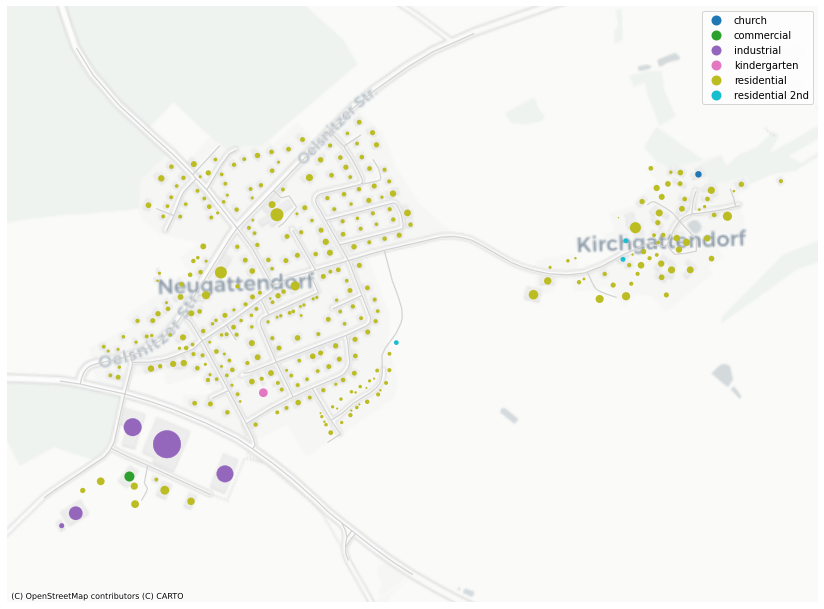

In [65]:
# Plotten
fig=plt.figure(figsize=hKartenFormat,dpi=Rm.dpiSize)

plotNFD(gdf_FWVB = fwvb.sort_values(by = 'W0', ascending = False)
       
       ,gdf_ROHR =edges
     #  ,Map_resolution = 15 # 18
      # ,LabelsOnTop = True
     
          
       )
plt.tight_layout(pad=0.)

ax=plt.gca()

plt.savefig("{:s}A.jpg".format(pbfDateiHead),dpi=2*Rm.dpiSize)

## Berechnungen Zielplot

In [66]:
(xWorldMin,xWorldMax)=ax.get_xlim()
(yWorldMin,yWorldMax)=ax.get_ylim()
dxWorld=xWorldMax-xWorldMin
dyWorld=yWorldMax-yWorldMin
xWorldMin,xWorldMax,dxWorld,yWorldMin,yWorldMax,dyWorld,dxWorld/dyWorld
# (1646.1983657019446, 1209.3259177068248, 1.3612528612828672)

(712927.0168182495,
 714573.2151839514,
 1646.1983657019446,
 5578135.258965311,
 5579344.584883017,
 1209.3259177068248,
 1.3612528612828672)

In [67]:
#Image.MAX_IMAGE_PIXELS=None 
#img = Image.open("{:s}A.jpg".format(pbfDateiHead))
#img.width,img.height,img.width/img.height
##(26933, 19054, 1.4135089744935447)
os.remove("{:s}A.jpg".format(pbfDateiHead))

In [68]:
(xBlatt,yBlatt)=hKartenFormat
xBlatt,yBlatt

(11.69, 8.27)

In [69]:
xPlot=xBlatt
yPlot=xBlatt*dyWorld/dxWorld
(xPlot,yPlot,xPlot/yPlot)

(11.69, 8.587677082260198, 1.3612528612828672)

## Plot

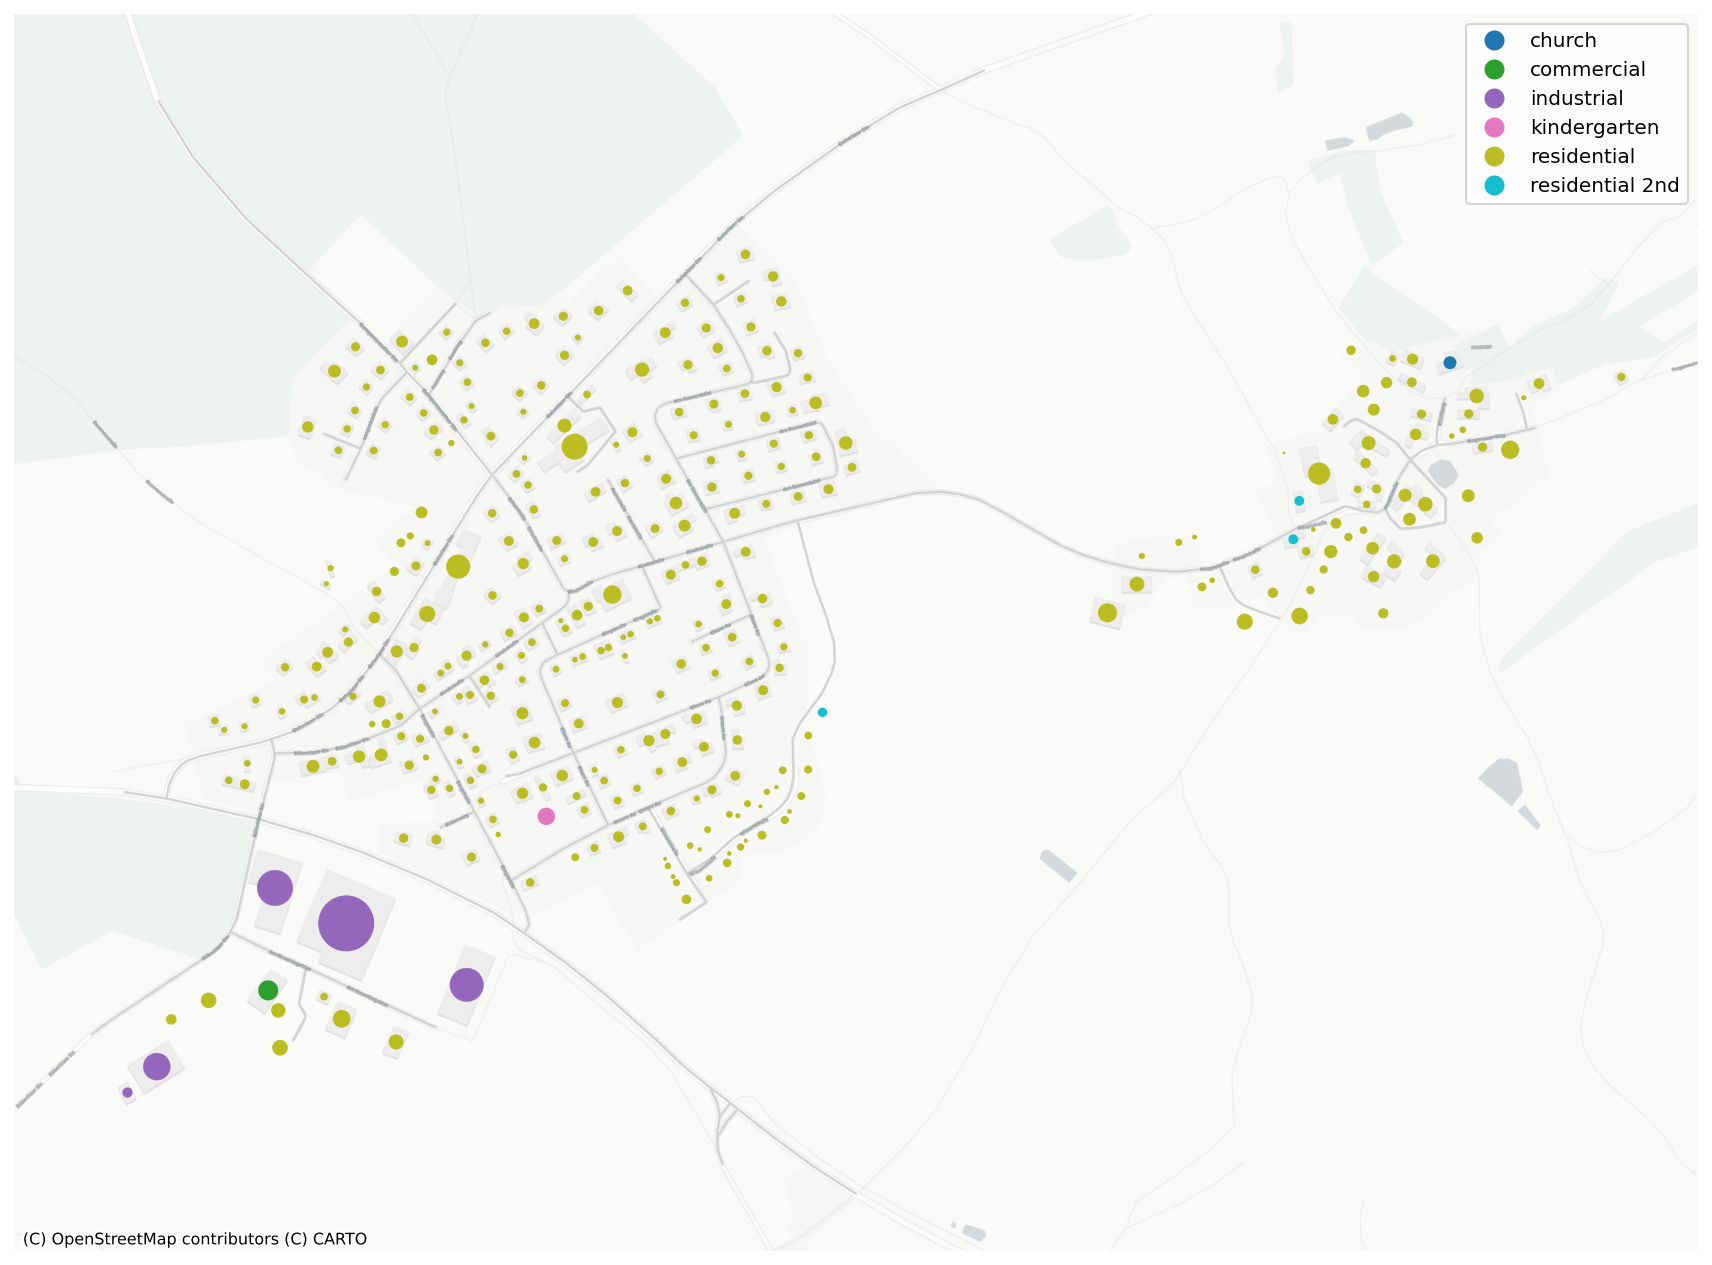

In [70]:
# Plotten
fig=plt.figure(figsize=(xPlot,yPlot),
               dpi=hKartenAufloesung)

plotNFD(gdf_FWVB = fwvb.sort_values(by = 'W0', ascending = False)
       
       ,gdf_ROHR =edges
       ,Map_resolution = 18
       ,LabelsOnTop = True
     
          
       )
plt.tight_layout(pad=0.)

ax=plt.gca()

plt.savefig("{:s}.jpg".format(pbfDateiHead),dpi=16*hKartenAufloesung)

In [71]:
(xWorldMin,xWorldMax)=ax.get_xlim()
(yWorldMin,yWorldMax)=ax.get_ylim()
Image.MAX_IMAGE_PIXELS=None 
img = Image.open("{:s}.jpg".format(pbfDateiHead))

#1
#2     3

with open("{:s}.jpgw".format(pbfDateiHead),'w') as f:
    
    f.write("{:16.10f}\n".format(0.001))
    f.write("{:16.10f}\n".format(0.001))
    f.write("{:16.10f}\n".format(0.001))
    f.write("{:16.10f}\n".format(0.001))
    # Ankerpunkt: 1 (Ursprung KOS Image)
    f.write("{:16.2f}\n".format(xWorldMin))
    f.write("{:16.2f}\n".format(yWorldMax))
    # 1
    f.write("[Pic(x,y)  Ground(X,Y)]\t{:17.2f}\t{:17.2f}\t{:17.2f}\t{:17.2f}\n".format(0.,0.,xWorldMin,yWorldMax))
    # 2
    f.write("[Pic(x,y)  Ground(X,Y)]\t{:17.2f}\t{:17.2f}\t{:17.2f}\t{:17.2f}\n".format(0.,img.height-1,xWorldMin,yWorldMin))
    # 3
    f.write("[Pic(x,y)  Ground(X,Y)]\t{:17.2f}\t{:17.2f}\t{:17.2f}\t{:17.2f}\n".format(img.width-1,img.height-1,xWorldMax,yWorldMin))